# Building clean font data based on glyphazzn_urls.txt

The team of Google Brain released a text file with urls of font files together with their paper "A Learned Representation for Scalable Vector Graphics" (https://arxiv.org/pdf/1904.02632v1.pdf) on the corresponding github repository (https://github.com/magenta/magenta/tree/main/magenta/models/svg_vae) under the url https://storage.googleapis.com/magentadata/models/svg_vae/glyphazzn_urls.txt We will explore this file and answer questions like:
- How many urls are in the file?
- How many of the urls are online?
- What are the websites of the urls?
- What are the file formats of the font files?
- How many of the fonts have a complete set of glyphs including special characters like Ü, Ä, Ö, ß, etc.?
- How many of the fonts have only the standard set of glyphs for the english language?

In [1]:
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm
import fontTools.ttLib as ttLib
#import urllib.request
import string
import os
#from fontTools.ttLib import TTFont
from PIL import Image, ImageFont, ImageDraw
import matplotlib.pyplot as plt


In [2]:
# Read in the csv file into a pandas dataframe
glyphazzn_urls_df = pd.read_csv('https://storage.googleapis.com/magentadata/models/svg_vae/glyphazzn_urls.txt', header=None)
# Add column names
glyphazzn_urls_df.columns = ['id', 'split', 'url']
glyphazzn_urls_df.head()

,id,split,url
0,10874912048437857480,train,http://www.xfont.ru/fonts/2/0/5/20509.ttf
1,11774248574169741770,train,http://www.eaglefonts.com/data/media/167/Cele...
2,11833345069570448668,train,http://www.eaglefonts.com/data/media/166/Bens...
3,12127215344058962203,train,http://www.eaglefonts.com/data/media/178/Nigh...
4,13166094153439943621,train,http://ru.fontsplace.com/free/fonts/e/elan_me...


The file contains three columns: An ID, a tag allocating it to train or test set, and a url for the font file.

In [3]:
# We make all urls lower case
glyphazzn_urls_df['url'] = glyphazzn_urls_df['url'].str.lower()
# We use describe to get a summary of the data
glyphazzn_urls_df.describe(include='all')

,id,split,url
count,6.626000e+04,66260,66260
unique,NaN,2,66230
top,NaN,train,http://2ttf.com/webfont/r4o2zl0u/webfont.ttf
freq,NaN,59635,5
mean,8.692529e+18,NaN,NaN
std,5.318652e+18,NaN,NaN
min,3.167458e+13,NaN,NaN
25%,4.037312e+18,NaN,NaN
50%,8.412318e+18,NaN,NaN
75%,1.322461e+19,NaN,NaN


There are 66_260 rows but only 66_230 unique urls. This means that there are 30 duplicates. We will remove them.

In [4]:
# Removing duplicates
glyphazzn_urls_df.drop_duplicates(subset='url', keep='first', inplace=True)

In [5]:
# Now we find out which different file formats are used
# We do this by splitting the url string at the last dot
# and then counting the different file formats
glyphazzn_urls_df['file_format'] = glyphazzn_urls_df['url'].str.split('.').str[-1]
glyphazzn_urls_df['file_format'].value_counts()

file_format
ttf                   48710
otf                    9021
pfb                    4237
pfa                       2
aspx?id=1085976787        1
                      ...  
aspx?id=451342200         1
aspx?id=617311713         1
aspx?id=762535020         1
aspx?id=975303412         1
aspx?id=1078155012        1
Name: count, Length: 4264, dtype: int64

The majority of the files are ttf files followed by otf and pfb files. We are not interested in any files with aspx and we do not care about the two files ending with pfa. We will remove them.

In [6]:
# Dropping all rows that do not have a file format ending in ttf, otf or pfb
glyphazzn_urls_df = glyphazzn_urls_df[glyphazzn_urls_df['file_format'].isin(['ttf', 'otf', 'pfb'])]
glyphazzn_urls_df['file_format'].value_counts()

file_format
ttf    48710
otf     9021
pfb     4237
Name: count, dtype: int64

In [7]:
# What are the unique websites?
# The strings of the urls are of the form http://www.website.com/...
# We split the url strings at the first slash
glyphazzn_urls_df['website'] = glyphazzn_urls_df['url'].str.split('/').str[2]
glyphazzn_urls_df['website'].value_counts()

website
www.eaglefonts.com     18022
www.fontslog.com        8695
www.fontsplace.com      8347
2ttf.com                6387
cd.textfiles.com        5774
www.xfont.ru            1623
ru.fontsplace.com       1502
fontsforweb.com         1333
www.911fonts.com        1256
www.deviantart.com      1232
xfont.ru                1143
www.andor.net            966
grafikk.vktv.net         877
paul-weaver.co.uk        850
fontm.com                762
photoshop.cc             599
www.mediafont.com        578
www.shriftik.ru          569
www.fonts101.com         537
npprint.com              518
andor.net                379
www.fontsforweb.com       13
www.photoshop.cc           6
Name: count, dtype: int64

In [8]:
# Now we check, which websites are offline
# We use the requests library to check the status code of the websites


# We store all unique websites in a list
unique_websites = glyphazzn_urls_df['website'].unique().tolist()
website_status_codes = {}
# We iterate over the list of unique websites and display a progress bar
for website in tqdm(unique_websites):
    # We try to get the status code of the website
    try:
        website_status_codes[website] = requests.get('https://' + website).status_code
    except:
        try:
            website_status_codes[website] = requests.get('http://' + website).status_code
        except:
            pass

# We create a new column called status_code
glyphazzn_urls_df['status_code'] = np.nan
# We iterate over the list of website_status_codes and and update the corresponding rows in the dataframe
for website, status_code in website_status_codes.items():
    glyphazzn_urls_df.loc[glyphazzn_urls_df['website'] == website, 'status_code'] = status_code

  0%|          | 0/23 [00:00<?, ?it/s]

100%|██████████| 23/23 [01:08<00:00,  2.99s/it]


In [9]:
# The websites, which are in the list of unique websites, but not in the list of website_status_codes are offline
offline_websites = list(set(unique_websites) - set(website_status_codes.keys()))
offline_websites

['www.andor.net',
 'andor.net',
 'www.911fonts.com',
 'ru.fontsplace.com',
 'grafikk.vktv.net']

In [10]:
# Removing all rows with offline websites (status_code != 200)
glyphazzn_urls_df = glyphazzn_urls_df[glyphazzn_urls_df['status_code'] == 200]
glyphazzn_urls_df.describe(include='all')

,id,split,url,file_format,website,status_code
count,5.698800e+04,56988,56988,56988,56988,56988.0
unique,NaN,2,56988,3,18,NaN
top,NaN,train,http://www.xfont.ru/fonts/2/0/5/20509.ttf,ttf,www.eaglefonts.com,NaN
freq,NaN,51305,1,43739,18022,NaN
mean,8.688754e+18,NaN,NaN,NaN,NaN,200.0
std,5.317683e+18,NaN,NaN,NaN,NaN,0.0
min,1.484443e+14,NaN,NaN,NaN,NaN,200.0
25%,4.036720e+18,NaN,NaN,NaN,NaN,200.0
50%,8.405575e+18,NaN,NaN,NaN,NaN,200.0
75%,1.322256e+19,NaN,NaN,NaN,NaN,200.0


## Analysis of font tables

In [11]:
def download_fonts(url_list, download_dir=None):
    if download_dir is None:
        download_dir = os.getcwd()

    files_downloaded = 0
    for url in tqdm(url_list):
        try:
            response = requests.get(url)
            if response.status_code == 200:
                font_file_name = os.path.basename(url)
                font_file_name_path = os.path.join(download_dir, font_file_name)
                with open(font_file_name_path, 'wb') as f:
                    f.write(response.content)
                    files_downloaded += 1
                
            else:
                pass#print(f"URL not reachable: {url}")
        except Exception as e:
            pass#print(f"Error processing {url}: {e}")
    print(f"Downloaded {files_downloaded} of {len(url_list)} files.")


In [12]:

def render_font(font_path, size, chars="ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789ÄäÖöÜüß"):
    font = ImageFont.truetype(font_path, size)
    arrays = []

    for char in chars:
        # Modes: 1 (1-bit pixels, black and white, stored with one pixel per byte)
        #        L (8-bit pixels, black and white)
        image = Image.new('L', (size, size), 1)
        draw = ImageDraw.Draw(image)
        draw.text((0, 0), char, font=font, fill=255)
        arrays.append(np.array(image).reshape((size, size, 1)))

    return arrays #np.concatenate(arrays, axis=2)


In [13]:

def sort_fonts(font_files_path=None, 
               processed_fonts_path=None,
               required_chars="ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789",#
               special_chars="ÄäÖöÜüß"):
    if font_files_path is None:
        font_files_path = os.getcwd()
    if processed_fonts_path is None:
        processed_fonts_path = font_files_path
    
    files = os.listdir(font_files_path)
    # only font files with ttf or otf or pfb extension
    font_files = [file for file in files if file.endswith(('.ttf', '.otf', '.pfb'))]

    num_fonts_required_chars = 0
    num_fonts_special_chars = 0
    for font_file in tqdm(font_files):
        font_file_path = os.path.join(font_files_path, font_file)

        try:
            font = ttLib.TTFont(font_file_path)
        except:
            os.remove(font_file_path)
            print(f"Removed corrupted file: {font_file_path}")
            continue
        available_chars = {chr(c) for t in font['cmap'].tables for c in t.cmap.keys()}

        all_chars = set(required_chars + special_chars)
        if all_chars.issubset(available_chars):
            # TODO: Check if the characters are realy in the font or if they are just a entry with no glyph
            os.makedirs(os.path.join(processed_fonts_path, 'with_special_chars'), exist_ok=True)
            os.rename(font_file_path, os.path.join(processed_fonts_path, 'with_special_chars', font_file))
            num_fonts_special_chars += 1
        elif set(required_chars).issubset(available_chars):
            # TODO: Check if the characters are realy in the font or if they are just a entry with no glyph
            os.makedirs(os.path.join(processed_fonts_path, 'with_required_chars'), exist_ok=True)
            os.rename(font_file_path, os.path.join(processed_fonts_path, 'with_required_chars', font_file))
            num_fonts_required_chars += 1
        else:
            os.makedirs(os.path.join(processed_fonts_path, 'not_all_chars_required'), exist_ok=True)
            os.rename(font_file_path, os.path.join(processed_fonts_path, 'not_all_chars_required', font_file))

    print(f"Found {len(font_files)} font files.")
    print(f"{num_fonts_required_chars} of them contain all required characters.")
    print(f"{num_fonts_special_chars} of them contain all required and special characters.")
    print(f"{len(font_files) - num_fonts_required_chars - num_fonts_special_chars} of them didn't have all required characters or were removed as an corrupted file.")
    #return num_fonts_required_chars, num_fonts_special_chars


In [14]:
urls_list = glyphazzn_urls_df['url'].tolist()
# the folder for downloading is one folder up and then data/raw/fonts
download_dir = os.path.join(os.pardir, 'data', 'raw', 'fonts')

In [15]:
if not os.path.exists(download_dir):
    os.makedirs(download_dir)
download_fonts(urls_list[:300], download_dir=download_dir)

100%|██████████| 300/300 [02:09<00:00,  2.31it/s]

Downloaded 44 of 300 files.


In [16]:
processed_fonts_path = os.path.join(os.pardir, 'data', 'processed', 'fonts')

In [17]:
if not os.path.exists(processed_fonts_path):
    os.makedirs(processed_fonts_path)
sort_fonts(font_files_path=download_dir, processed_fonts_path=processed_fonts_path)

100%|██████████| 44/44 [00:00<00:00, 72.64it/s]

Found 44 font files.
6 of them contain all required characters.
37 of them contain all required and special characters.
1 of them didn't have all required characters or were removed as an corrupted file.


Missing characters: {'K', 'L', '6', 'F', 'R', 'J', '4', '2', 'N', 'E', 'O', '1', 'S', '7', '0', 'H', 'Y', '8', '9', 'G', 'Q', 'V', 'Z', 'C', 'D', 'I', 'X', 'T', 'P', '3', 'U', 'B', 'W', '5', 'A', 'M'}


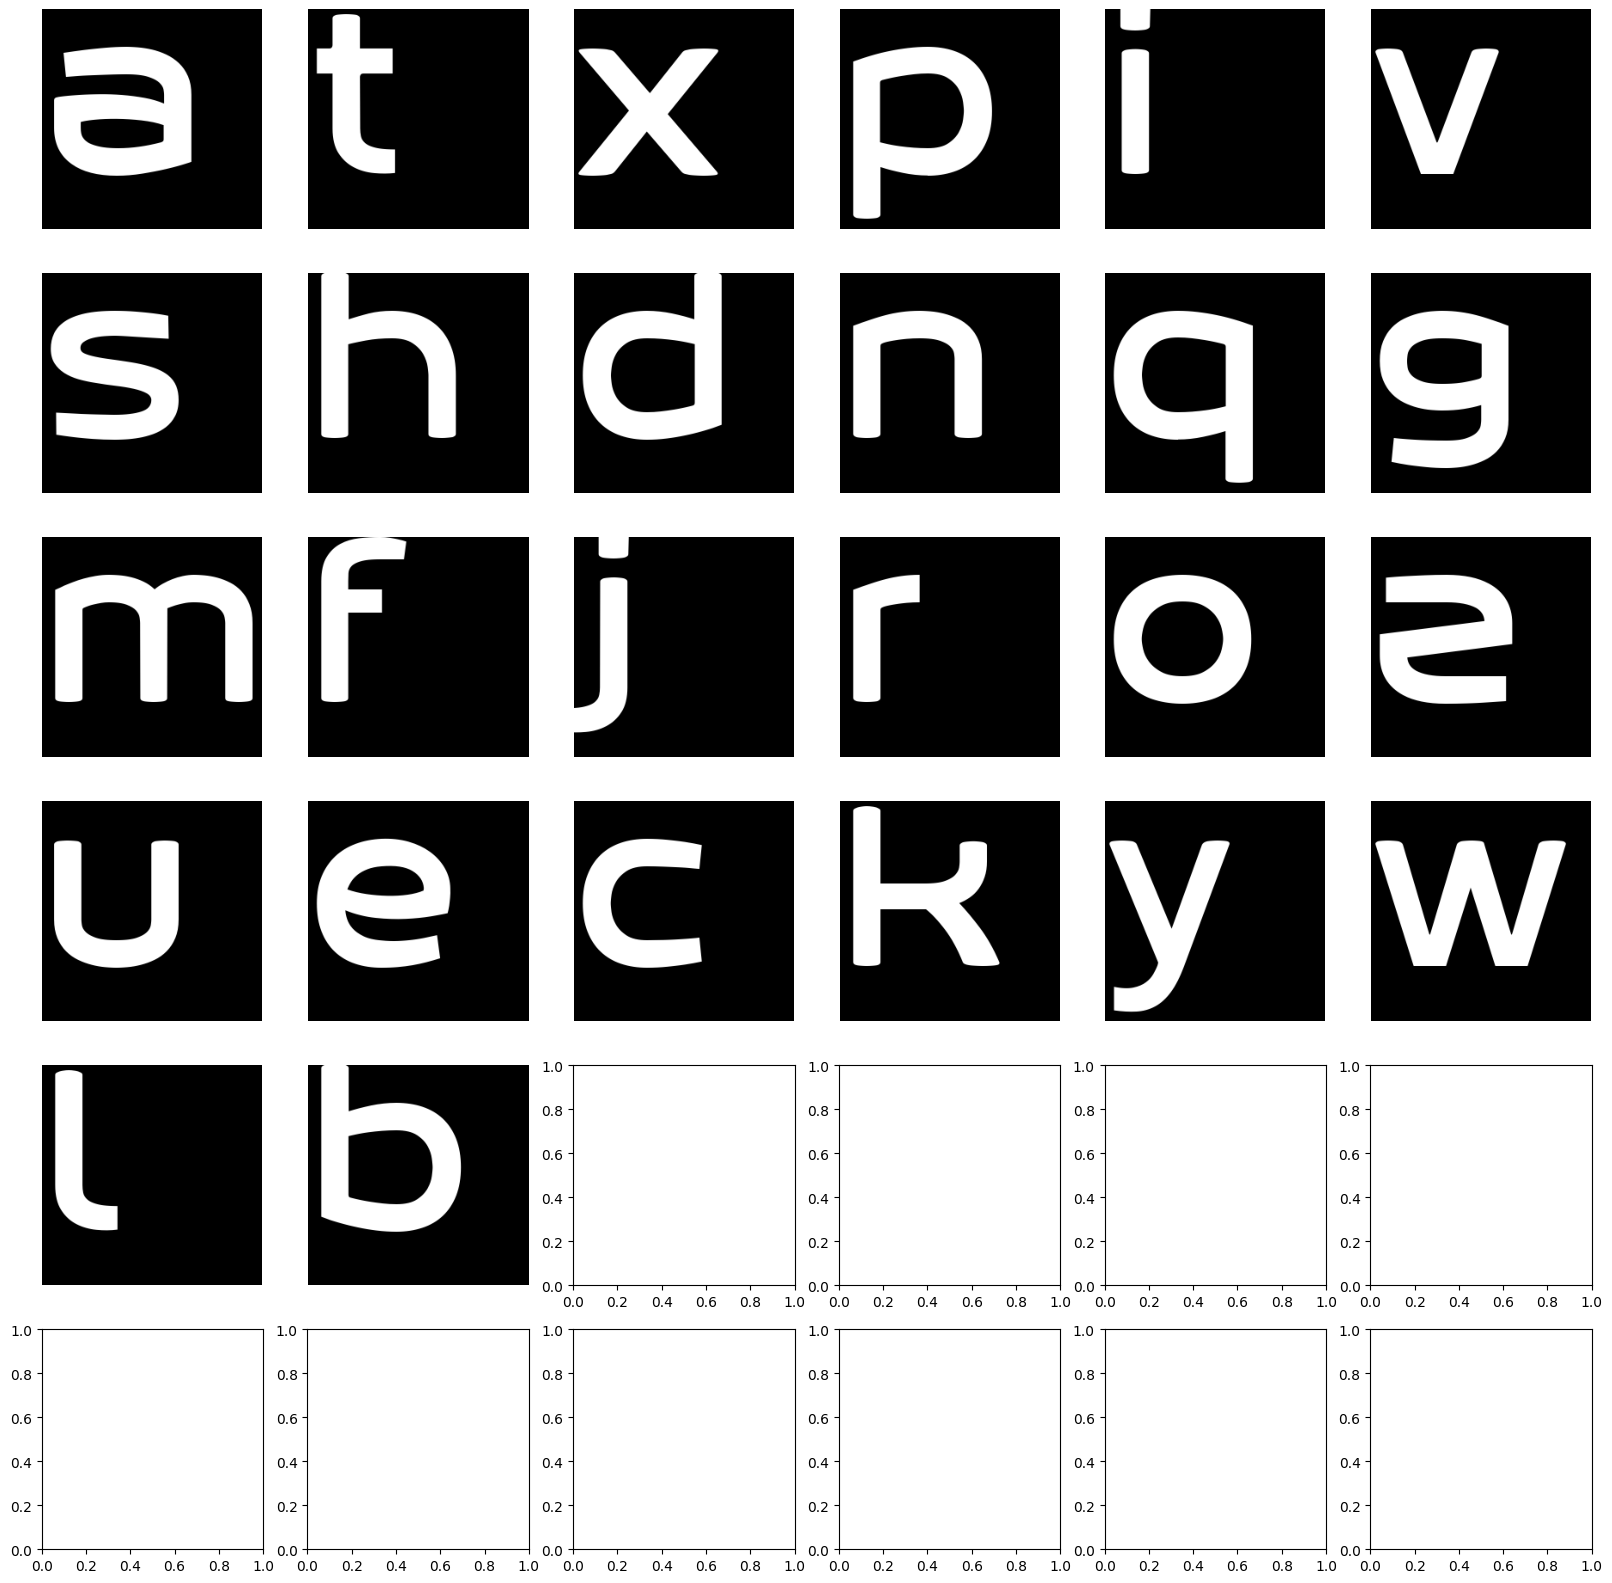

In [18]:
chars_to_check = set("ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789")
special_chars = set("ÄäÖöÜüß")

# Let's have a look at one of the fonts, that doesn't contain all required characters
path = os.path.join(processed_fonts_path, 'not_all_chars_required')
font_file = os.listdir(path)[0]
font_file_path = os.path.join(path, font_file)

font = ttLib.TTFont(font_file_path)

available_chars = {chr(c) for t in font['cmap'].tables for c in t.cmap.keys()}
missing_chars = chars_to_check - available_chars
available_chars_of_required_chars = available_chars & chars_to_check
print(f"Missing characters: {missing_chars}")

size = int(np.ceil(np.sqrt(len(available_chars_of_required_chars))))
fig, ax = plt.subplots(size, size, figsize=(20, 20))

glyph_arrays = render_font(font_file_path, 256, chars=available_chars_of_required_chars)
for i, glyph_array in enumerate(glyph_arrays):
    ax[i // size, i % size].imshow(glyph_array, cmap='gray')
    ax[i // size, i % size].axis('off')    

There are oviously fonts, that do not even have the standard set of glyphs for the english language.

37it [00:00, 38.54it/s]


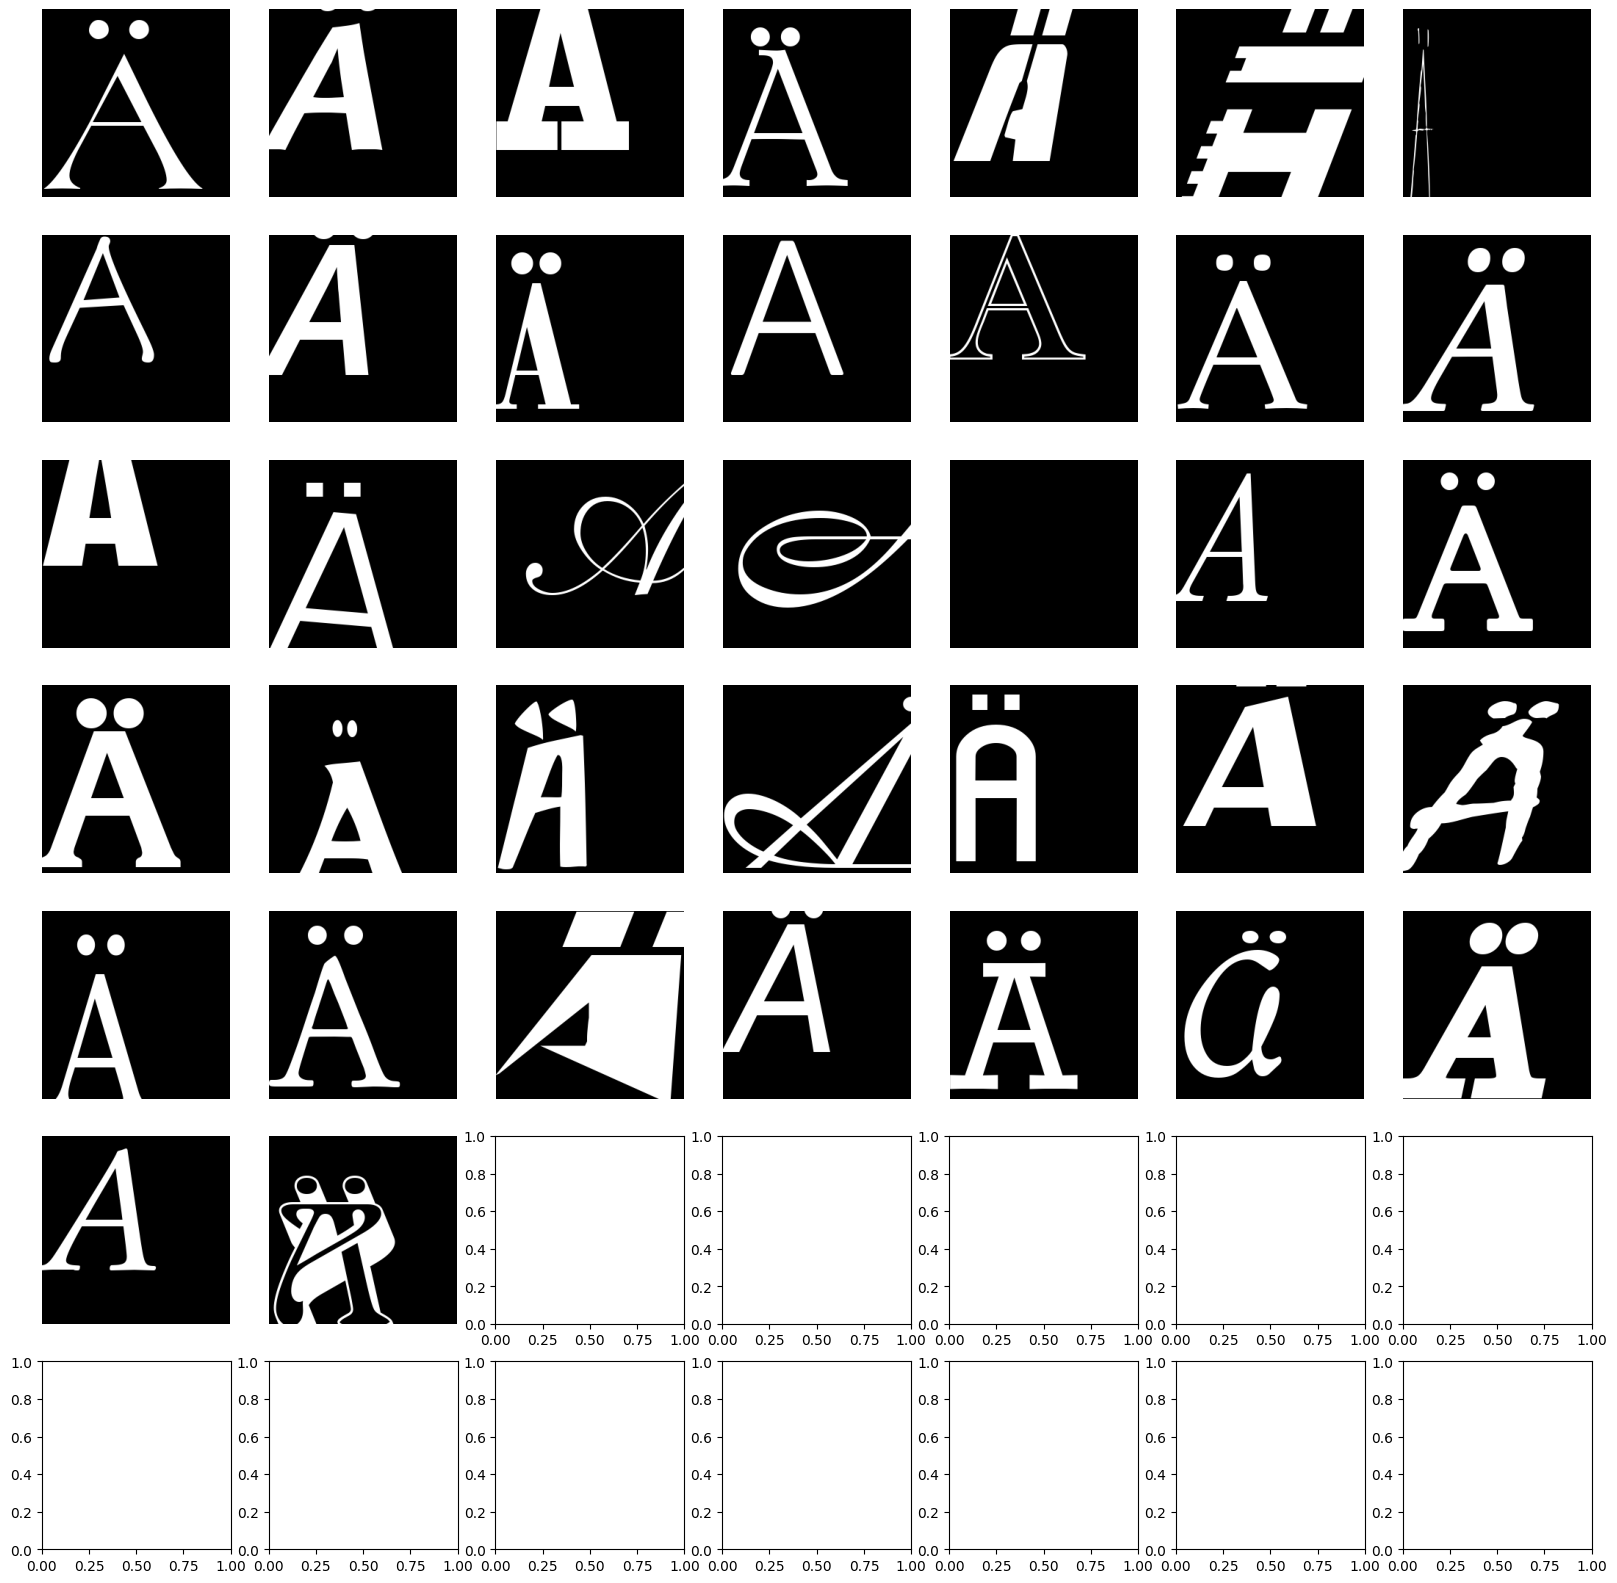

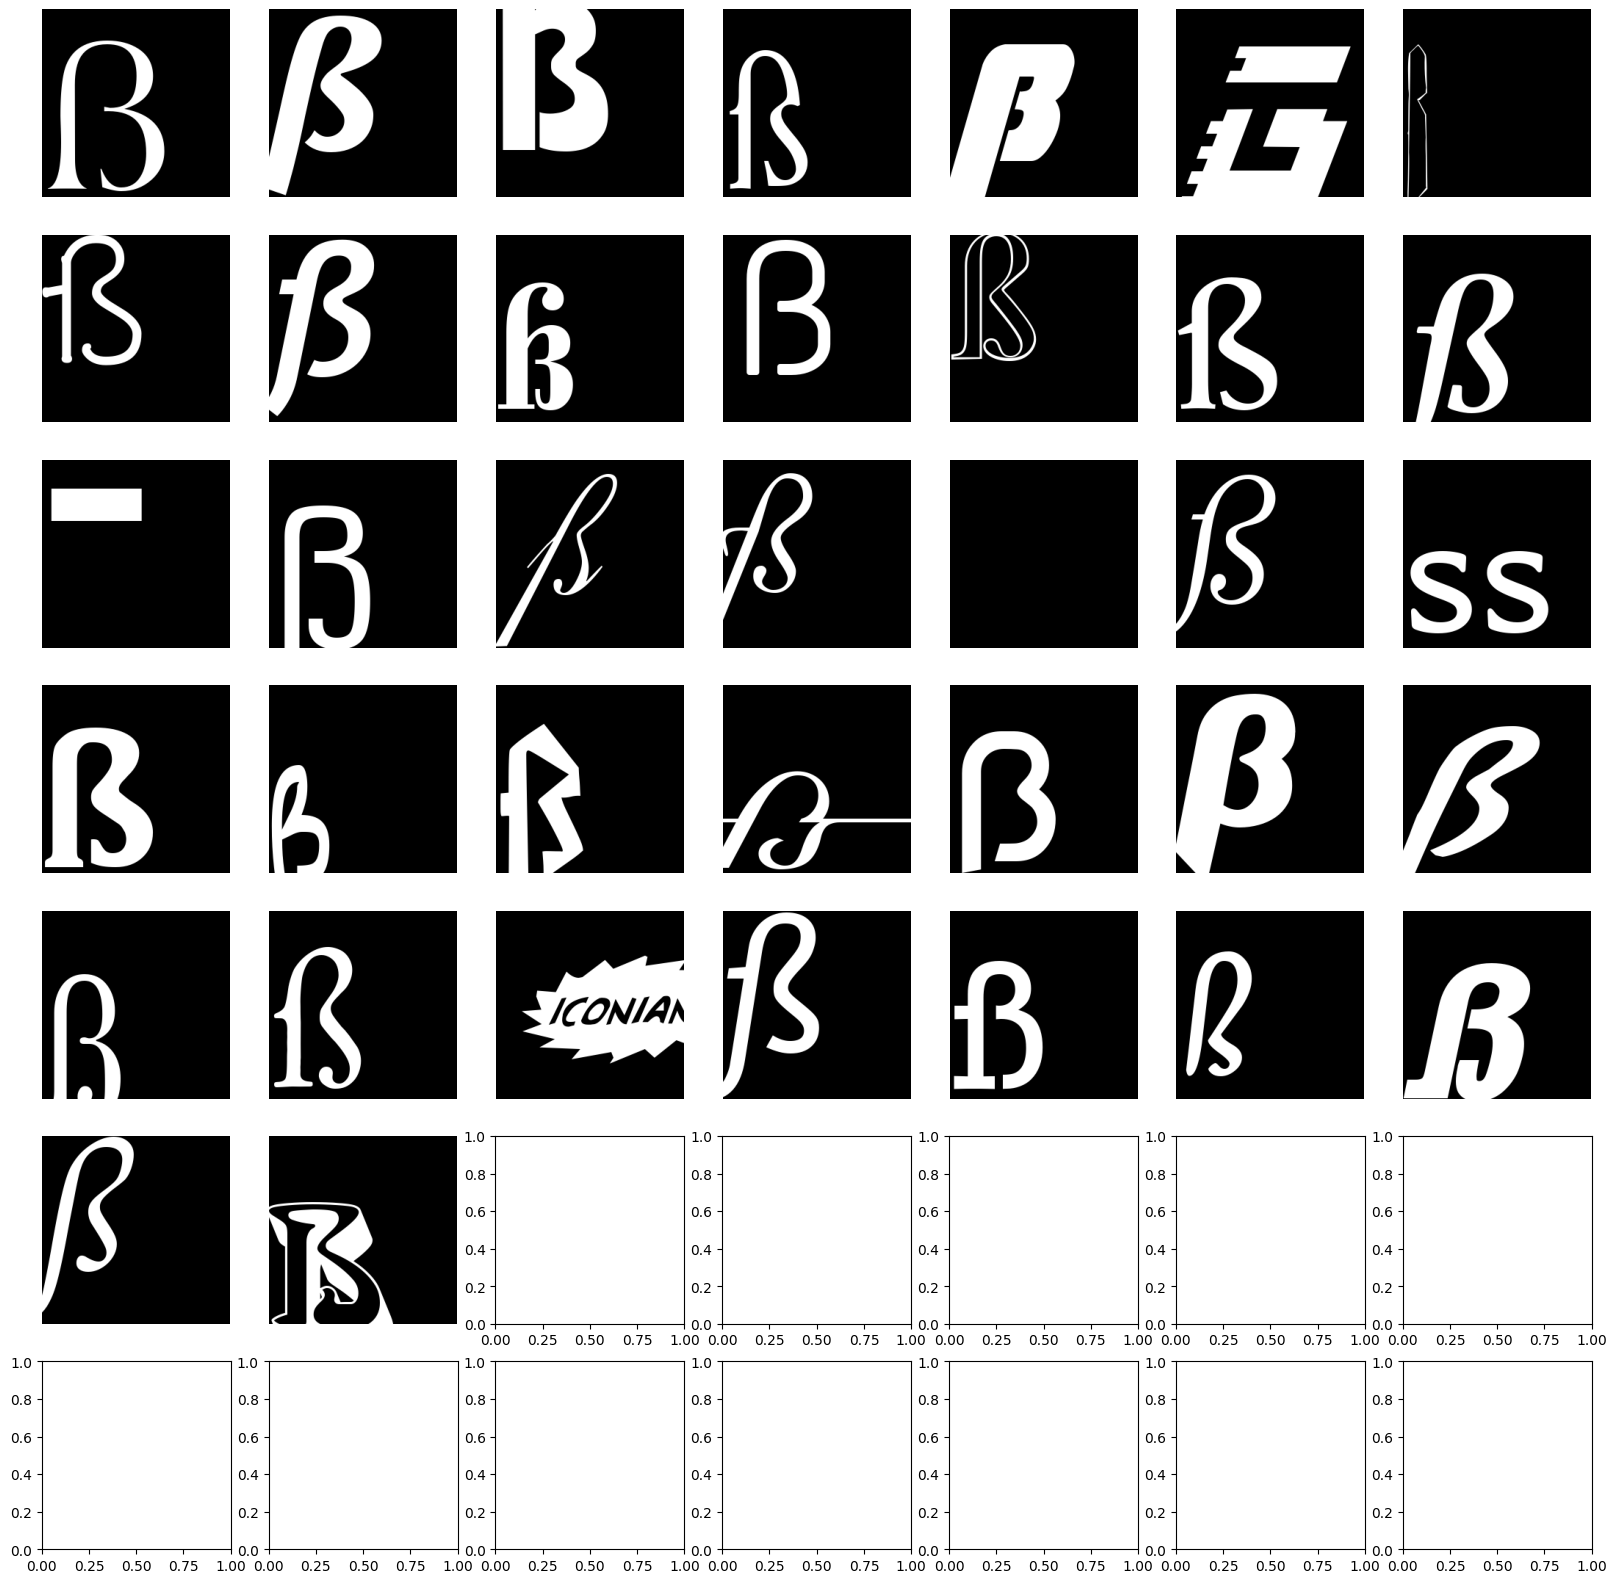

In [19]:
path = os.path.join(processed_fonts_path, 'with_special_chars')
font_file_names = os.listdir(path)

num_fonts = len(font_file_names)
size = int(np.ceil(np.sqrt(num_fonts)))

fig, ax = plt.subplots(size, size, figsize=(20, 20))
fig2, ax2 = plt.subplots(size, size, figsize=(20, 20))

for i, font_file_name in tqdm(enumerate(font_file_names)):
    font_file_name_path = os.path.join(path, font_file_name)
    font_array = render_font(font_file_name_path, 256)
    # plt.imshow(font_array[:, :, 62], cmap='gray')
    ax[i // size, i % size].imshow(font_array[62], cmap='gray')
    # turning axis off
    ax[i // size, i % size].axis('off')

    ax2[i // size, i % size].imshow(font_array[68], cmap='gray')
    ax2[i // size, i % size].axis('off')

plt.show()


For some fonts, people didn't create the characters, but just left the field of the table empty. In this case the character shows up in the cmap table, but the glyph is empty. We need to handle these cases.

And some people just replace the ß with ss or put completely different symbols into the glyphs. How should we handle these cases?

And a lot of fonts are not defined well within the boarders of the glyph. We need to find a way to handle these cases as well.

## Function: check for empty glyphs

In [20]:
# two fonts tables, we will work with for building the function
# A font table with the Ä fully within the rendered box:
font_file_name_with_adieresis = font_file_names[0]

font_file_name_path = os.path.join(path, font_file_name_with_adieresis)
font_with_adieresis = ttLib.TTFont(font_file_name_path)
print(font_file_name_with_adieresis)
print(font_with_adieresis['cmap'].getBestCmap()[196])

amidb_normal.ttf
Adieresis


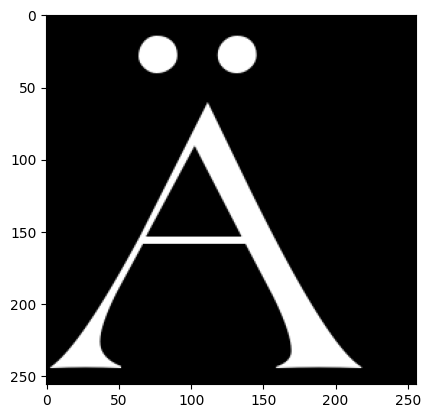

In [21]:
font_array = render_font(font_file_name_path, 256)
plt.imshow(font_array[62], cmap='gray')

In [22]:
# A font table with the Ä in the cmap table, but the entry is empty:
font_file_name_without_adieresis = font_file_names[18]

font_file_name_path = os.path.join(path, font_file_name_without_adieresis)
font_without_adieresis = ttLib.TTFont(font_file_name_path)
print(font_file_name_without_adieresis)
print(font_without_adieresis['cmap'].getBestCmap()[196])

peamarcieskinnyscript.ttf
Adieresis


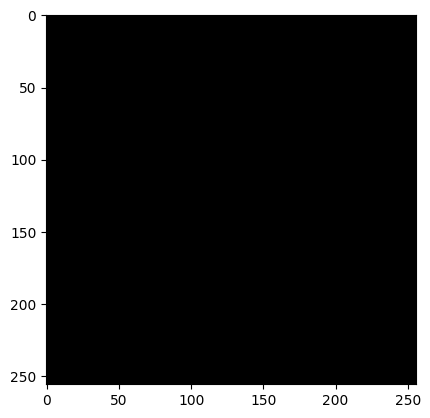

In [23]:
font_array = render_font(font_file_name_path, 256)
plt.imshow(font_array[62], cmap='gray')

In [24]:
# A font with a Adieresis glyph has a path in the glyf table
adieresis_path = font_with_adieresis['glyf'].glyphs['Adieresis']
adieresis_path.data

'modified' timestamp out of range; ignoring top bytes


b'\x00\x04\x00\x17\x00\x00\x06\xd3\x072\x00\x0c\x00\x18\x00;\x00>\x00u@0\x01??@@7<:*>=87-,(\'%\x1c\x1a\x19\x16\x10\n\x04\r\x01\x00\x08\x07! \x07>=\x07\x131\x038,(\x03\x19\x01\x01,Fv/7\x18\x00?\x17<?/</<\xfd<\x10\xfd<<\x01................\x00...10\x01Ih\xb9\x00,\x00?Iha\xb0@RX8\x117\xb9\x00?\xff\xc08Y\x01#"&54632\x16\x15\x14\x06!"&54676\x16\x15\x14\x06\x015654\'&\'%\x06\x07\x06\x15\x14\x17\x15&#"\x0756\x01\x12\x13\x16\x17\x12\x17\x12\x17\x15&#"\t\x01!\x04!\x02*?@+0<C\xfe\x1a%?9+2AF\x02iTdMM\xfd\xc9IH]ucbbb\xaa\x01J\xba\xbatt\xbb\x89\xbbmvwv\xfd\xc7\xfe\xf2\x02\x12\x06^;*+A;/*=<$-E\x01\x01<3+:\xf9\xa2\x08\x1b=a\xcb\x92\x92\x02\x86\x86\xb9Z[.\n\x05\x05\x04t\x02f\x01p\x01p\xef\xef\xfe\x85\xe5\xfe\xc6@\x06\x05\x04\xca\xfe\x0c'

In [25]:
# Alternatively, we can get the Adieresis glyph by the string "Ä" from the cmap table
adieresis_path = font_with_adieresis['glyf'].glyphs[font_with_adieresis['cmap'].getBestCmap()[ord('Ä')]]
adieresis_path.data

b'\x00\x04\x00\x17\x00\x00\x06\xd3\x072\x00\x0c\x00\x18\x00;\x00>\x00u@0\x01??@@7<:*>=87-,(\'%\x1c\x1a\x19\x16\x10\n\x04\r\x01\x00\x08\x07! \x07>=\x07\x131\x038,(\x03\x19\x01\x01,Fv/7\x18\x00?\x17<?/</<\xfd<\x10\xfd<<\x01................\x00...10\x01Ih\xb9\x00,\x00?Iha\xb0@RX8\x117\xb9\x00?\xff\xc08Y\x01#"&54632\x16\x15\x14\x06!"&54676\x16\x15\x14\x06\x015654\'&\'%\x06\x07\x06\x15\x14\x17\x15&#"\x0756\x01\x12\x13\x16\x17\x12\x17\x12\x17\x15&#"\t\x01!\x04!\x02*?@+0<C\xfe\x1a%?9+2AF\x02iTdMM\xfd\xc9IH]ucbbb\xaa\x01J\xba\xbatt\xbb\x89\xbbmvwv\xfd\xc7\xfe\xf2\x02\x12\x06^;*+A;/*=<$-E\x01\x01<3+:\xf9\xa2\x08\x1b=a\xcb\x92\x92\x02\x86\x86\xb9Z[.\n\x05\x05\x04t\x02f\x01p\x01p\xef\xef\xfe\x85\xe5\xfe\xc6@\x06\x05\x04\xca\xfe\x0c'

In [26]:
# We see, that a glyth with a path has a data attribute, while a glyph without a path doesn't have a data attribute
# We can use this to check fonts for empty glyphs

def glyph_is_empty(glyph):
    return not hasattr(glyph, 'data')

def has_empty_glyphs(font: ttLib.TTFont, chars_to_check: str = None):
    if chars_to_check is None:
        chars_to_check = {chr(c) for c in font['cmap'].getBestCmap().keys()}

    for char in chars_to_check:
        glyph = font['glyf'].glyphs[font['cmap'].getBestCmap()[ord(char)]]
        if glyph_is_empty(glyph):
            return True
    return False

In [27]:
# Now we can detect fonts, that have a glyph in the cmap table, but no path in the glyf table
has_empty_glyphs(font_with_adieresis, chars_to_check="Ä")

False

In [28]:
has_empty_glyphs(font_without_adieresis, chars_to_check="Ä")

True

In [29]:
# function to check if a font has all required characters
def has_all_chars(font: ttLib.TTFont, chars_to_check: str):
    # chars_in_font = {chr(c) for c in font['cmap'].tables[1].cmap.keys()}
    chars_in_font = {chr(c) for c in font['cmap'].getBestCmap().keys()}
    return set(chars_to_check).issubset(chars_in_font) and not has_empty_glyphs(font, chars_to_check)

With that we have a new sort_fonts function that checks for empty glyphs and places them into the corresponding folder.

In [56]:
def sort_fonts(font_files_path=None, 
               processed_fonts_path=None,
               required_chars="ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789",#
               special_chars="ÄäÖöÜüß"):
    if font_files_path is None:
        font_files_path = os.getcwd()
    if processed_fonts_path is None:
        processed_fonts_path = font_files_path
    
    files = os.listdir(font_files_path)
    # only font files with ttf or otf or pfb extension
    font_files = [file for file in files if file.endswith(('.ttf', '.otf'))] #, '.pfb'))] <-- only trouble with these files

    num_fonts_required_chars = 0
    num_fonts_special_chars = 0
    for font_file in tqdm(font_files):
        font_file_path = os.path.join(font_files_path, font_file)
        # print(font_file_path)

        try:
            font = ttLib.TTFont(font_file_path)
        except:
            os.remove(font_file_path)
            print(f"Removed corrupted file: {font_file_path}")
            continue

        # TODO: Understand font files with less than 3 tables and possibly include them
        # if len(font['cmap'].tables) < 3:
        #     os.remove(font_file_path)
        #     print(f"Removed corrupted file: {font_file_path}")
        #     continue

        #TODO: Understand fonts without key "glyf" and possibly include them
        if 'glyf' not in font.keys():
            os.remove(font_file_path)
            print(f"Removed corrupted file: {font_file_path}")
            continue
        try:
            _ = font['glyf']
        except:
            os.remove(font_file_path)
            print(f"Removed corrupted file: {font_file_path}")
            continue
        if font['cmap'].getBestCmap() is None:
            os.remove(font_file_path)
            print(f"Removed corrupted file: {font_file_path}")
            continue

        all_chars = set(required_chars + special_chars)
        if has_all_chars(font, all_chars):
            os.makedirs(os.path.join(processed_fonts_path, 'with_special_chars'), exist_ok=True)
            os.rename(font_file_path, os.path.join(processed_fonts_path, 'with_special_chars', font_file))
            num_fonts_special_chars += 1
        elif has_all_chars(font, required_chars):
            os.makedirs(os.path.join(processed_fonts_path, 'with_required_chars'), exist_ok=True)
            os.rename(font_file_path, os.path.join(processed_fonts_path, 'with_required_chars', font_file))
            num_fonts_required_chars += 1
        else:
            os.makedirs(os.path.join(processed_fonts_path, 'not_all_chars_required'), exist_ok=True)
            os.rename(font_file_path, os.path.join(processed_fonts_path, 'not_all_chars_required', font_file))

In [31]:
# Repeating the sorting of the fonts with the updated function
# First we need to get all fonts back into the folder ../raw/fonts (download_dir) from the folder (and all subfolders in) ../processed/fonts (processed_fonts_path)
for root, dirs, files in os.walk(processed_fonts_path):
    for file in files:
        os.rename(os.path.join(root, file), os.path.join(download_dir, file))

In [32]:
if not os.path.exists(processed_fonts_path):
    os.makedirs(processed_fonts_path)
sort_fonts(font_files_path=download_dir, processed_fonts_path=processed_fonts_path)

 48%|████▊     | 21/44 [00:00<00:00, 98.04it/s]'created' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
 73%|███████▎  | 32/44 [00:00<00:00, 102.32it/s]'created' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
100%|██████████| 44/44 [00:00<00:00, 102.18it/s]


156it [00:03, 44.26it/s]


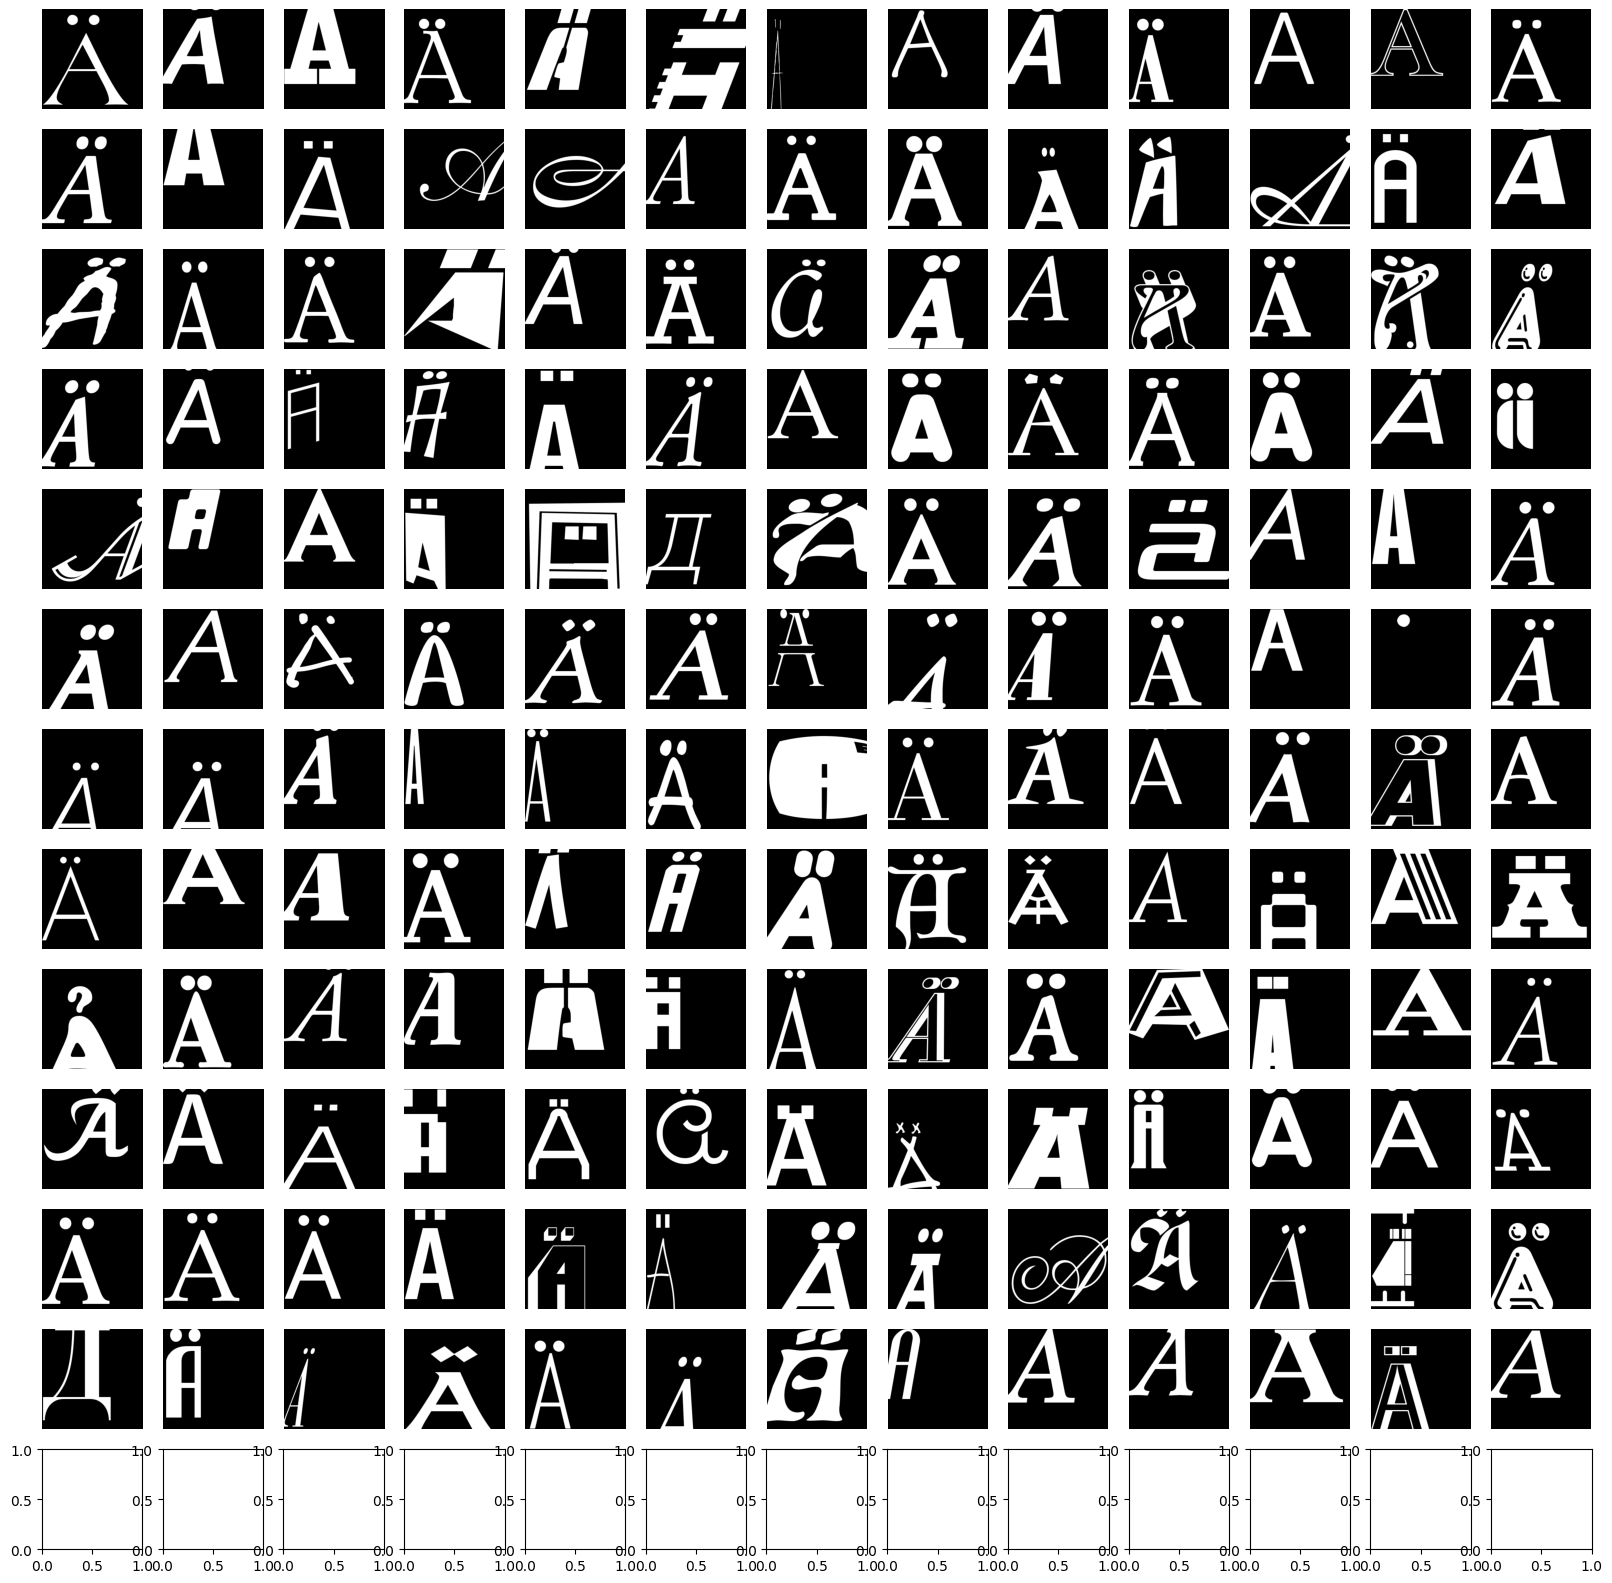

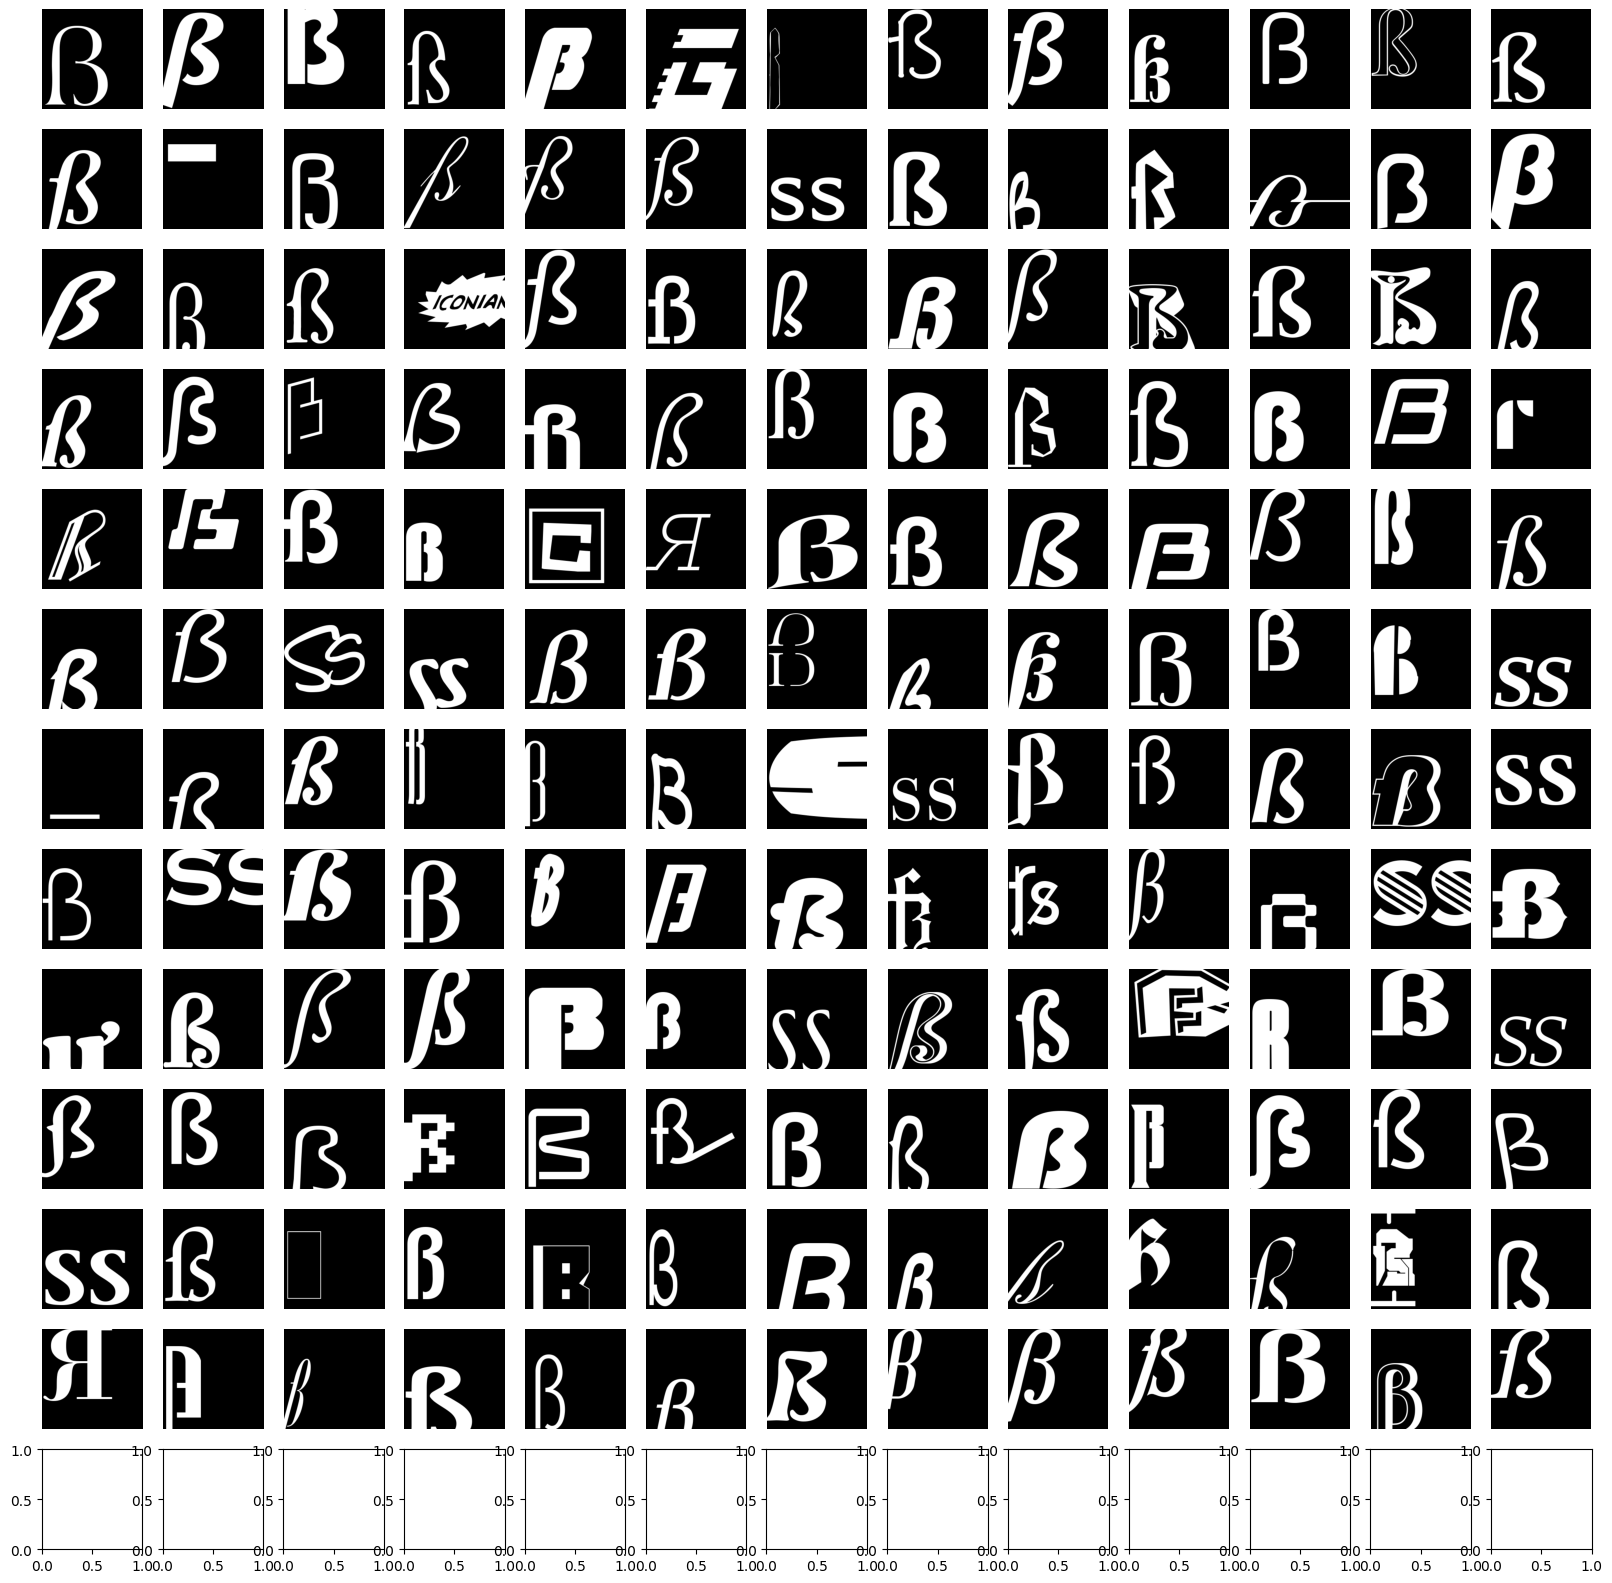

In [58]:
path = os.path.join(processed_fonts_path, 'with_special_chars')
font_file_names = os.listdir(path)

num_fonts = len(font_file_names)
size = int(np.ceil(np.sqrt(num_fonts)))

fig, ax = plt.subplots(size, size, figsize=(20, 20))
fig2, ax2 = plt.subplots(size, size, figsize=(20, 20))

for i, font_file_name in tqdm(enumerate(font_file_names)):
    font_file_name_path = os.path.join(path, font_file_name)
    font_array = render_font(font_file_name_path, 256)
    # plt.imshow(font_array[:, :, 62], cmap='gray')
    ax[i // size, i % size].imshow(font_array[62], cmap='gray')
    # turning axis off
    ax[i // size, i % size].axis('off')

    ax2[i // size, i % size].imshow(font_array[68], cmap='gray')
    ax2[i // size, i % size].axis('off')

plt.show()

It worked! We got rid of the empty glyphs.

## Fitting Glyphs inside a pixel grid

![Font Metrics](https://upload.wikimedia.org/wikipedia/commons/3/39/Typography_Line_Terms.svg)

The Font Metrics are defined in the following way:
- The Baseline is the line that the letters sit on.
- The Mean Line is the line that the majority of the lowercase letters sit on.
- The X-Height is the distance from the baseline to the top of the lowercase letters.
- The Cap Height is the distance from the baseline to the top of the uppercase letters.
- The Ascender is the part of a lowercase letter that extends above the mean line of a font.
- The Descender is the part of a lowercase letter that extends below the baseline of a font.


These lines are not fixed boarders for the glyphs, but rather guidelines for the font designer. For example, the pointy part of a small v need to extend below the baseline in order to have an harmonic look of the font. Otherwise, the v looks too small and seems so hover over the baseline.

We need to find out, which tolerance we can accept for the glyphs to fit into a pixel grid. For this we need to consider the hight and the width of glyphs. Firsst the height:

In [34]:
# The quad of a font is the bounding box of the glyphs (kind of definded by the length of the string "em")
# The number of units can be 1000, 2048, ...
# The number of units is the descender + ascender
# for quad = 1000, the descender is -200 and the ascender is 800
# This number is found in the head table of the font
print(font_with_adieresis['head'].__dict__)
print(font_with_adieresis['head'].unitsPerEm)

{'tableTag': 'head', 'tableVersion': 1.0, 'fontRevision': 1.0, 'checkSumAdjustment': 3982598034, 'magicNumber': 1594834165, 'flags': 0, 'unitsPerEm': 2048, 'created': 2861824439, 'modified': 2861824439, 'xMin': -193, 'yMin': -492, 'xMax': 2435, 'yMax': 1958, 'macStyle': 0, 'lowestRecPPEM': 3, 'fontDirectionHint': 2, 'indexToLocFormat': 1, 'glyphDataFormat': 0}
2048


In [35]:
# And there is also xMin, yMin, xMax, yMax in there :-D
print(font_with_adieresis['head'].xMin)
print(font_with_adieresis['head'].yMin)
print(font_with_adieresis['head'].xMax)
print(font_with_adieresis['head'].yMax)

-193
-492
2435
1958


In [36]:
# Let's check these numbers for a reosonable font a crazy font
font_file_name_reosonable = font_file_names[4]
font_file_name_path = os.path.join(path, font_file_name_reosonable)
font_reosonable = ttLib.TTFont(font_file_name_path)
print(font_reosonable['head'].unitsPerEm)
print(font_reosonable['head'].xMin)
print(font_reosonable['head'].yMin)
print(font_reosonable['head'].xMax)
print(font_reosonable['head'].yMax)

1000
-104
-195
1051
808


In [37]:
font_file_name_crazy = font_file_names[18]
font_file_name_path = os.path.join(path, font_file_name_crazy)
font_crazy = ttLib.TTFont(font_file_name_path)
print(font_crazy['head'].unitsPerEm)
print(font_crazy['head'].xMin)
print(font_crazy['head'].yMin)
print(font_crazy['head'].xMax)
print(font_crazy['head'].yMax)

1000
-159
-250
863
894


In [38]:
# The get a proper statistic in the following, we need to get more fonts and sort them first
if not os.path.exists(download_dir):
    os.makedirs(download_dir)
download_fonts(urls_list[300:1300], download_dir=download_dir)

100%|██████████| 1000/1000 [06:55<00:00,  2.40it/s]

Downloaded 153 of 1000 files.


In [55]:
if not os.path.exists(processed_fonts_path):
    os.makedirs(processed_fonts_path)
sort_fonts(font_files_path=download_dir, processed_fonts_path=processed_fonts_path)

  0%|          | 0/59 [00:00<?, ?it/s]'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
2 extra bytes in post.stringData array
 14%|█▎        | 8/59 [00:00<00:00, 70.36it/s]'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


..\data\raw\fonts\multihora.ttf
Removed corrupted file: ..\data\raw\fonts\multihora.ttf
..\data\raw\fonts\icone.ttf
..\data\raw\fonts\aphasia_bt_roman.ttf
..\data\raw\fonts\bauerboddregitare1.ttf
..\data\raw\fonts\geistbold.ttf
..\data\raw\fonts\crashbangwallop-highlight.ttf
..\data\raw\fonts\commadorwideheavy_normal.ttf
..\data\raw\fonts\orgrex_b.ttf
..\data\raw\fonts\proforma-lightitalicsc.ttf
..\data\raw\fonts\new_calligraph.ttf
..\data\raw\fonts\mondialplus_normal_pdf.ttf
..\data\raw\fonts\ericwide_normal.ttf
..\data\raw\fonts\scriptometersanscript.ttf
..\data\raw\fonts\assemblerregular.ttf
..\data\raw\fonts\kulukundis_itc1.ttf


 41%|████      | 24/59 [00:00<00:00, 76.55it/s]

..\data\raw\fonts\carlbecker_bold.ttf
..\data\raw\fonts\tatida_versal.ttf
..\data\raw\fonts\cloisterboldroman.ttf
..\data\raw\fonts\courtgesture.ttf
..\data\raw\fonts\rogerbecker-heavy_italic.ttf
..\data\raw\fonts\farriericg-bold.ttf
..\data\raw\fonts\roice-black.ttf
..\data\raw\fonts\printdashed_ot.otf
Removed corrupted file: ..\data\raw\fonts\printdashed_ot.otf
..\data\raw\fonts\peastefanieva.ttf
..\data\raw\fonts\shinnbook.ttf
..\data\raw\fonts\feggolitehatched.ttf
..\data\raw\fonts\stoneserscitcteesem.ttf
..\data\raw\fonts\evangelic.ttf
..\data\raw\fonts\paltusantno3lee.ttf
..\data\raw\fonts\charlotte_sans_small_caps_let.ttf
..\data\raw\fonts\focuscondmedium-regular_db.ttf


'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp out of range; ignoring top bytes
'modified' timestamp out of range; ignoring top bytes
 54%|█████▍    | 32/59 [00:00<00:00, 72.48it/s]'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
 68%|██████▊   | 40/59 [00:00<00:00, 66.95it/s]'created' timestamp out of range; ignoring top bytes
'modified' timestamp out of range; ignoring top bytes


..\data\raw\fonts\baddogscapsssk_italic.ttf
..\data\raw\fonts\colourb_regular.ttf
..\data\raw\fonts\pioneer_regular.ttf
..\data\raw\fonts\florleft.ttf
..\data\raw\fonts\blazing_regular.ttf
..\data\raw\fonts\cobalt_bolditalic.ttf
..\data\raw\fonts\geo986thin_bolditalic.ttf
..\data\raw\fonts\00700.ttf
..\data\raw\fonts\gallows_pole_1.ttf
..\data\raw\fonts\ballistadisplayscriptssk.ttf
..\data\raw\fonts\pepper_normal.ttf
..\data\raw\fonts\throhandregular-italic.ttf
..\data\raw\fonts\stealth-model.ttf


'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
 93%|█████████▎| 55/59 [00:00<00:00, 68.98it/s]

..\data\raw\fonts\francishighlighted_normal.ttf
..\data\raw\fonts\pt_didona_cyrillic.ttf
..\data\raw\fonts\lee_capitals.ttf
..\data\raw\fonts\nathanbrazilcond.ttf
..\data\raw\fonts\bordeauxdreg_italic.ttf
..\data\raw\fonts\barrettextended_bold.ttf
..\data\raw\fonts\steeptypewriter.ttf
..\data\raw\fonts\roomycondensed_italic.ttf
..\data\raw\fonts\freedomextended_italic.ttf
..\data\raw\fonts\lithia-lightitalic.ttf
..\data\raw\fonts\century_schoolbook_l_italic.ttf
..\data\raw\fonts\waverlymediumitalic.ttf
..\data\raw\fonts\primus_wide_sf_bold.ttf


'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
100%|██████████| 59/59 [00:00<00:00, 70.08it/s]

..\data\raw\fonts\newsgottmedre1.ttf
..\data\raw\fonts\urw_antiqua_t_regular_wide_oblique.ttf


In [59]:
# We want to display xMin, yMin, xMax, yMax relative to the quad (unitsPerEm) for all fonts
# First we save these values for all fonts in a dataframe
font_data = []
for font_file_name in tqdm(font_file_names):
    font_file_name_path = os.path.join(path, font_file_name)
    font = ttLib.TTFont(font_file_name_path)
    font_data.append([font_file_name, font['head'].unitsPerEm, font['head'].xMin, font['head'].yMin, font['head'].xMax, font['head'].yMax])

font_data_df = pd.DataFrame(font_data, columns=['font_file_name', 'unitsPerEm', 'xMin', 'yMin', 'xMax', 'yMax'])
font_data_df.head()

  0%|          | 0/156 [00:00<?, ?it/s]'modified' timestamp out of range; ignoring top bytes
'created' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
 17%|█▋        | 27/156 [00:00<00:00, 266.16it/s]'created' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
 40%|███▉      | 62/156 [00:00<00:00, 314.86it/s]'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp out of range; ign

,font_file_name,unitsPerEm,xMin,yMin,xMax,yMax
0,amidb_normal.ttf,2048,-193,-492,2435,1958
1,wunderlich-bolditalic.ttf,1000,-124,-248,1146,901
2,aiwood-antiquecondensed.ttf,1000,-42,-239,965,1046
3,lucasbecker-extralight.ttf,1000,-128,-233,984,940
4,freedomfightercondital.ttf,1000,-104,-195,1051,808


In [60]:
# Calculate the relative values xMin_rel, yMin_rel, xMax_rel, yMax_rel
font_data_df['xMin_rel'] = font_data_df['xMin'] / font_data_df['unitsPerEm']
font_data_df['yMin_rel'] = font_data_df['yMin'] / font_data_df['unitsPerEm']
font_data_df['xMax_rel'] = font_data_df['xMax'] / font_data_df['unitsPerEm']
font_data_df['yMax_rel'] = font_data_df['yMax'] / font_data_df['unitsPerEm']
font_data_df.head()

,font_file_name,unitsPerEm,xMin,yMin,xMax,yMax,xMin_rel,yMin_rel,xMax_rel,yMax_rel
0,amidb_normal.ttf,2048,-193,-492,2435,1958,-0.094238,-0.240234,1.188965,0.956055
1,wunderlich-bolditalic.ttf,1000,-124,-248,1146,901,-0.124000,-0.248000,1.146000,0.901000
2,aiwood-antiquecondensed.ttf,1000,-42,-239,965,1046,-0.042000,-0.239000,0.965000,1.046000
3,lucasbecker-extralight.ttf,1000,-128,-233,984,940,-0.128000,-0.233000,0.984000,0.940000
4,freedomfightercondital.ttf,1000,-104,-195,1051,808,-0.104000,-0.195000,1.051000,0.808000


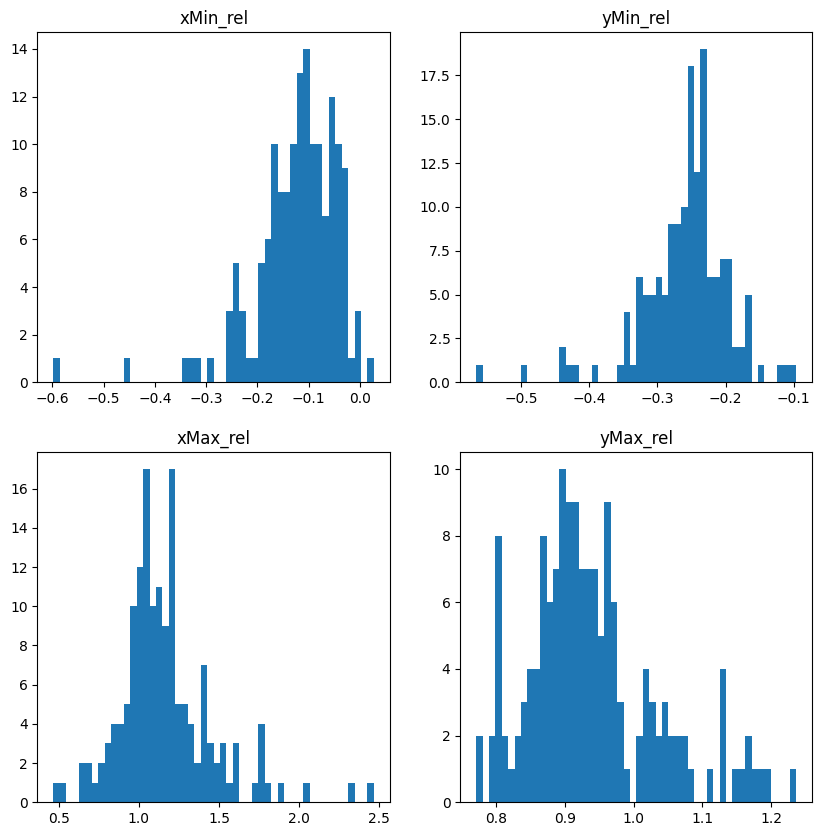

In [63]:
# Plotting the distribution of the relative values in a histogram in one plot together
bins = 50
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].hist(font_data_df['xMin_rel'], bins=bins)
ax[0, 0].set_title('xMin_rel')
ax[0, 1].hist(font_data_df['yMin_rel'], bins=bins)
ax[0, 1].set_title('yMin_rel')
ax[1, 0].hist(font_data_df['xMax_rel'], bins=bins)
ax[1, 0].set_title('xMax_rel')
ax[1, 1].hist(font_data_df['yMax_rel'], bins=bins)
ax[1, 1].set_title('yMax_rel')
plt.show()

In [135]:
def render_font(font_path, 
                size, 
                chars="ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789ÄäÖöÜüß"):
    font_size = int(0.7*size)
    text_start = (int(0.15*size), int(0.15*size))
    font = ImageFont.truetype(font_path, font_size)
    arrays = []

    for char in chars:
        # Modes: 1 (1-bit pixels, black and white, stored with one pixel per byte)
        #        L (8-bit pixels, black and white)
        image = Image.new('L', (size, size), 255)
        draw = ImageDraw.Draw(image)
        draw.text(text_start, char, font=font, fill=0)
        arrays.append(np.array(image).reshape((size, size, 1)))

    return arrays #np.concatenate(arrays, axis=2)

In [136]:
path = os.path.join(processed_fonts_path, 'with_special_chars')
font_file_names = os.listdir(path)

def plot_adieresis_and_sz(path, font_file_names):
    num_fonts = len(font_file_names)
    size = int(np.ceil(np.sqrt(num_fonts)))

    fig, ax = plt.subplots(size, size, figsize=(20, 20))
    fig2, ax2 = plt.subplots(size, size, figsize=(20, 20))

    for i, font_file_name in tqdm(enumerate(font_file_names)):
        font_file_name_path = os.path.join(path, font_file_name)
        font_array = render_font(font_file_name_path, 64)
        # plt.imshow(font_array[:, :, 62], cmap='gray')
        ax[i // size, i % size].imshow(font_array[62], cmap='gray')
        # turning axis off
        #ax[i // size, i % size].axis('off')

        ax2[i // size, i % size].imshow(font_array[68], cmap='gray')
        #ax2[i // size, i % size].axis('off')

    plt.show()

71it [00:00, 168.44it/s]


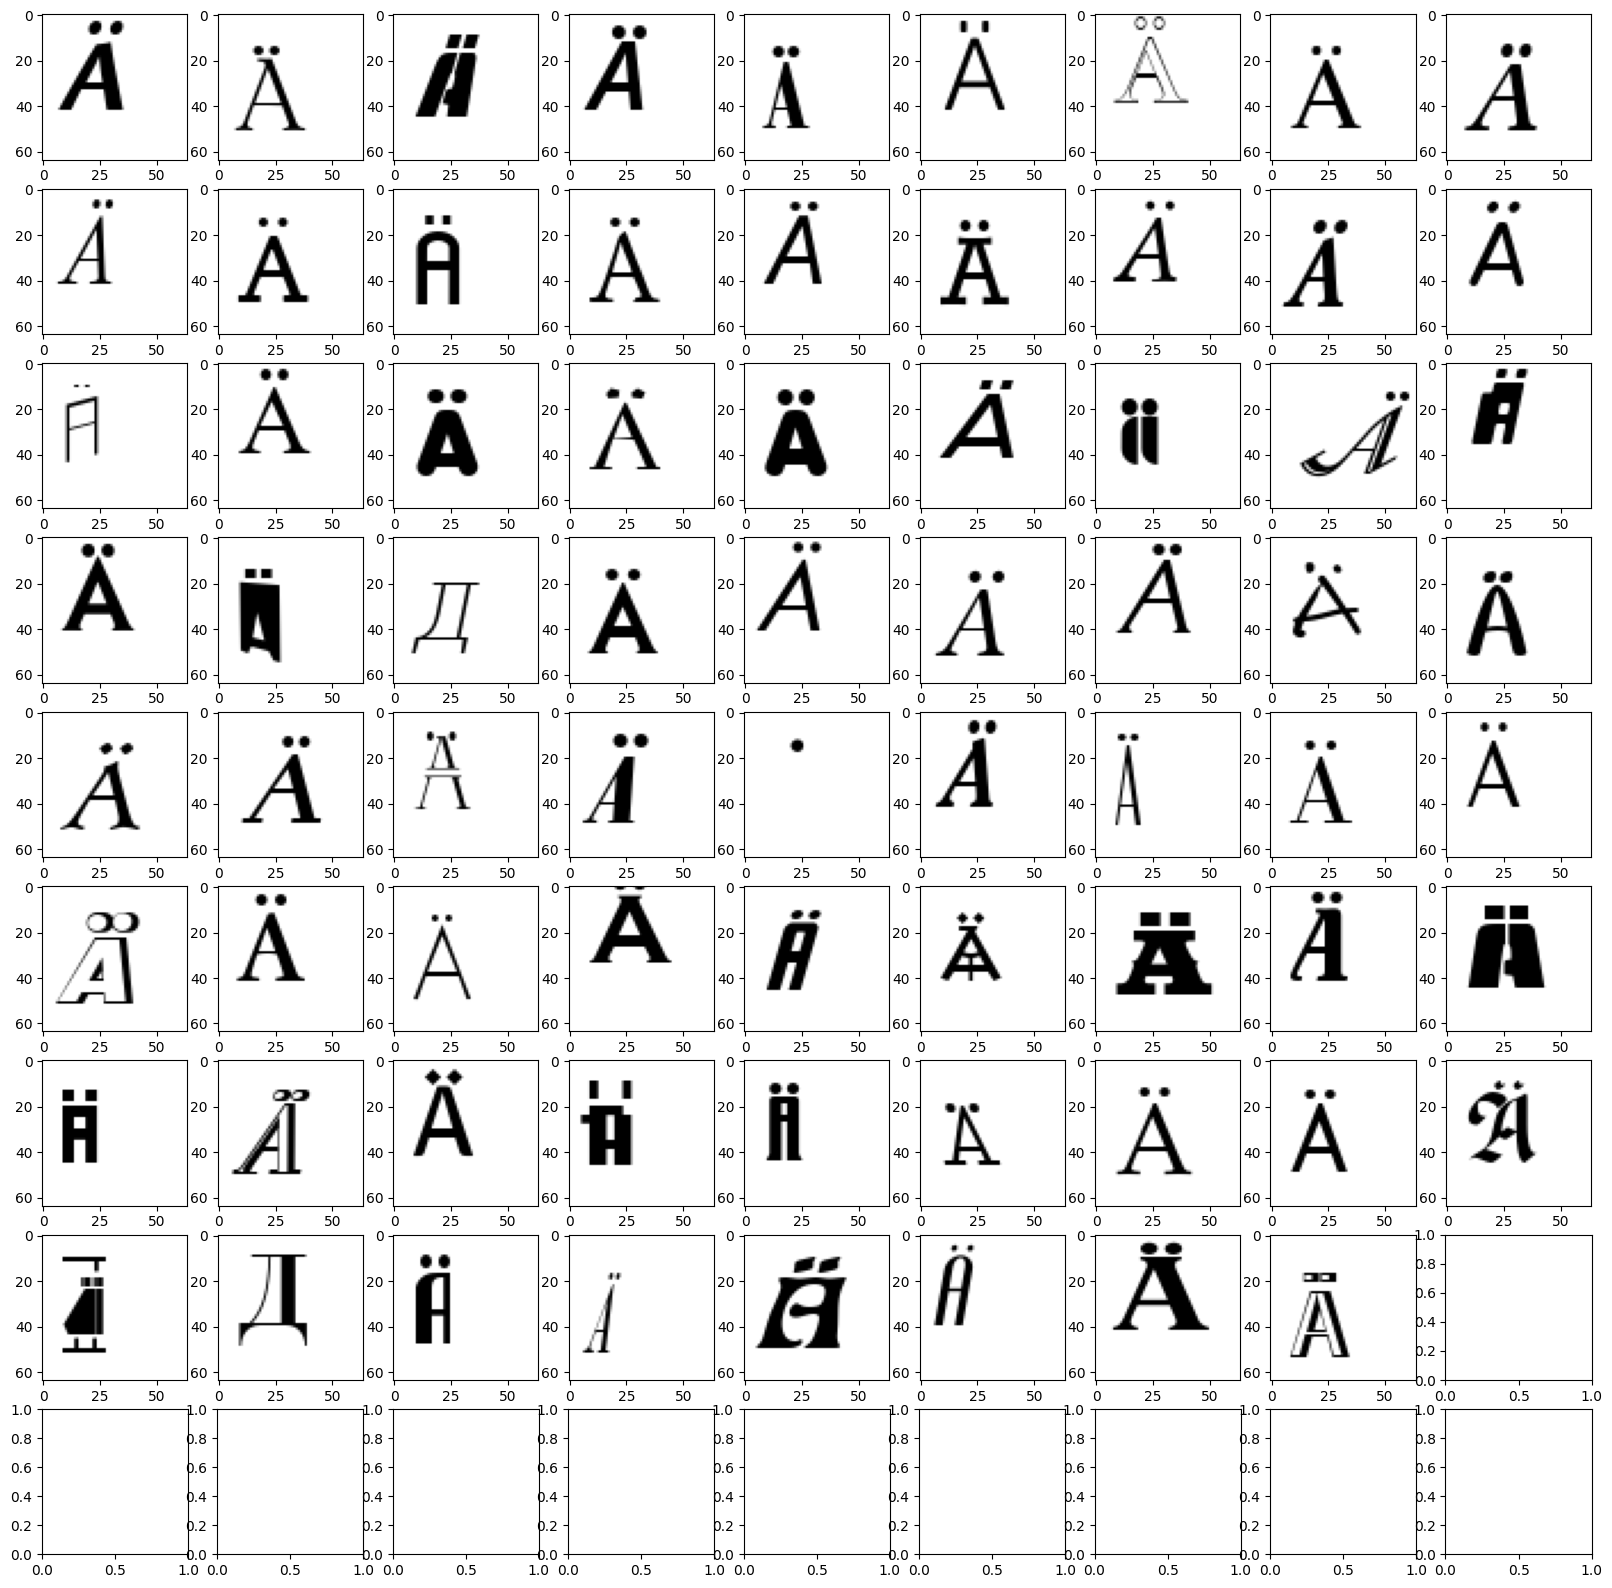

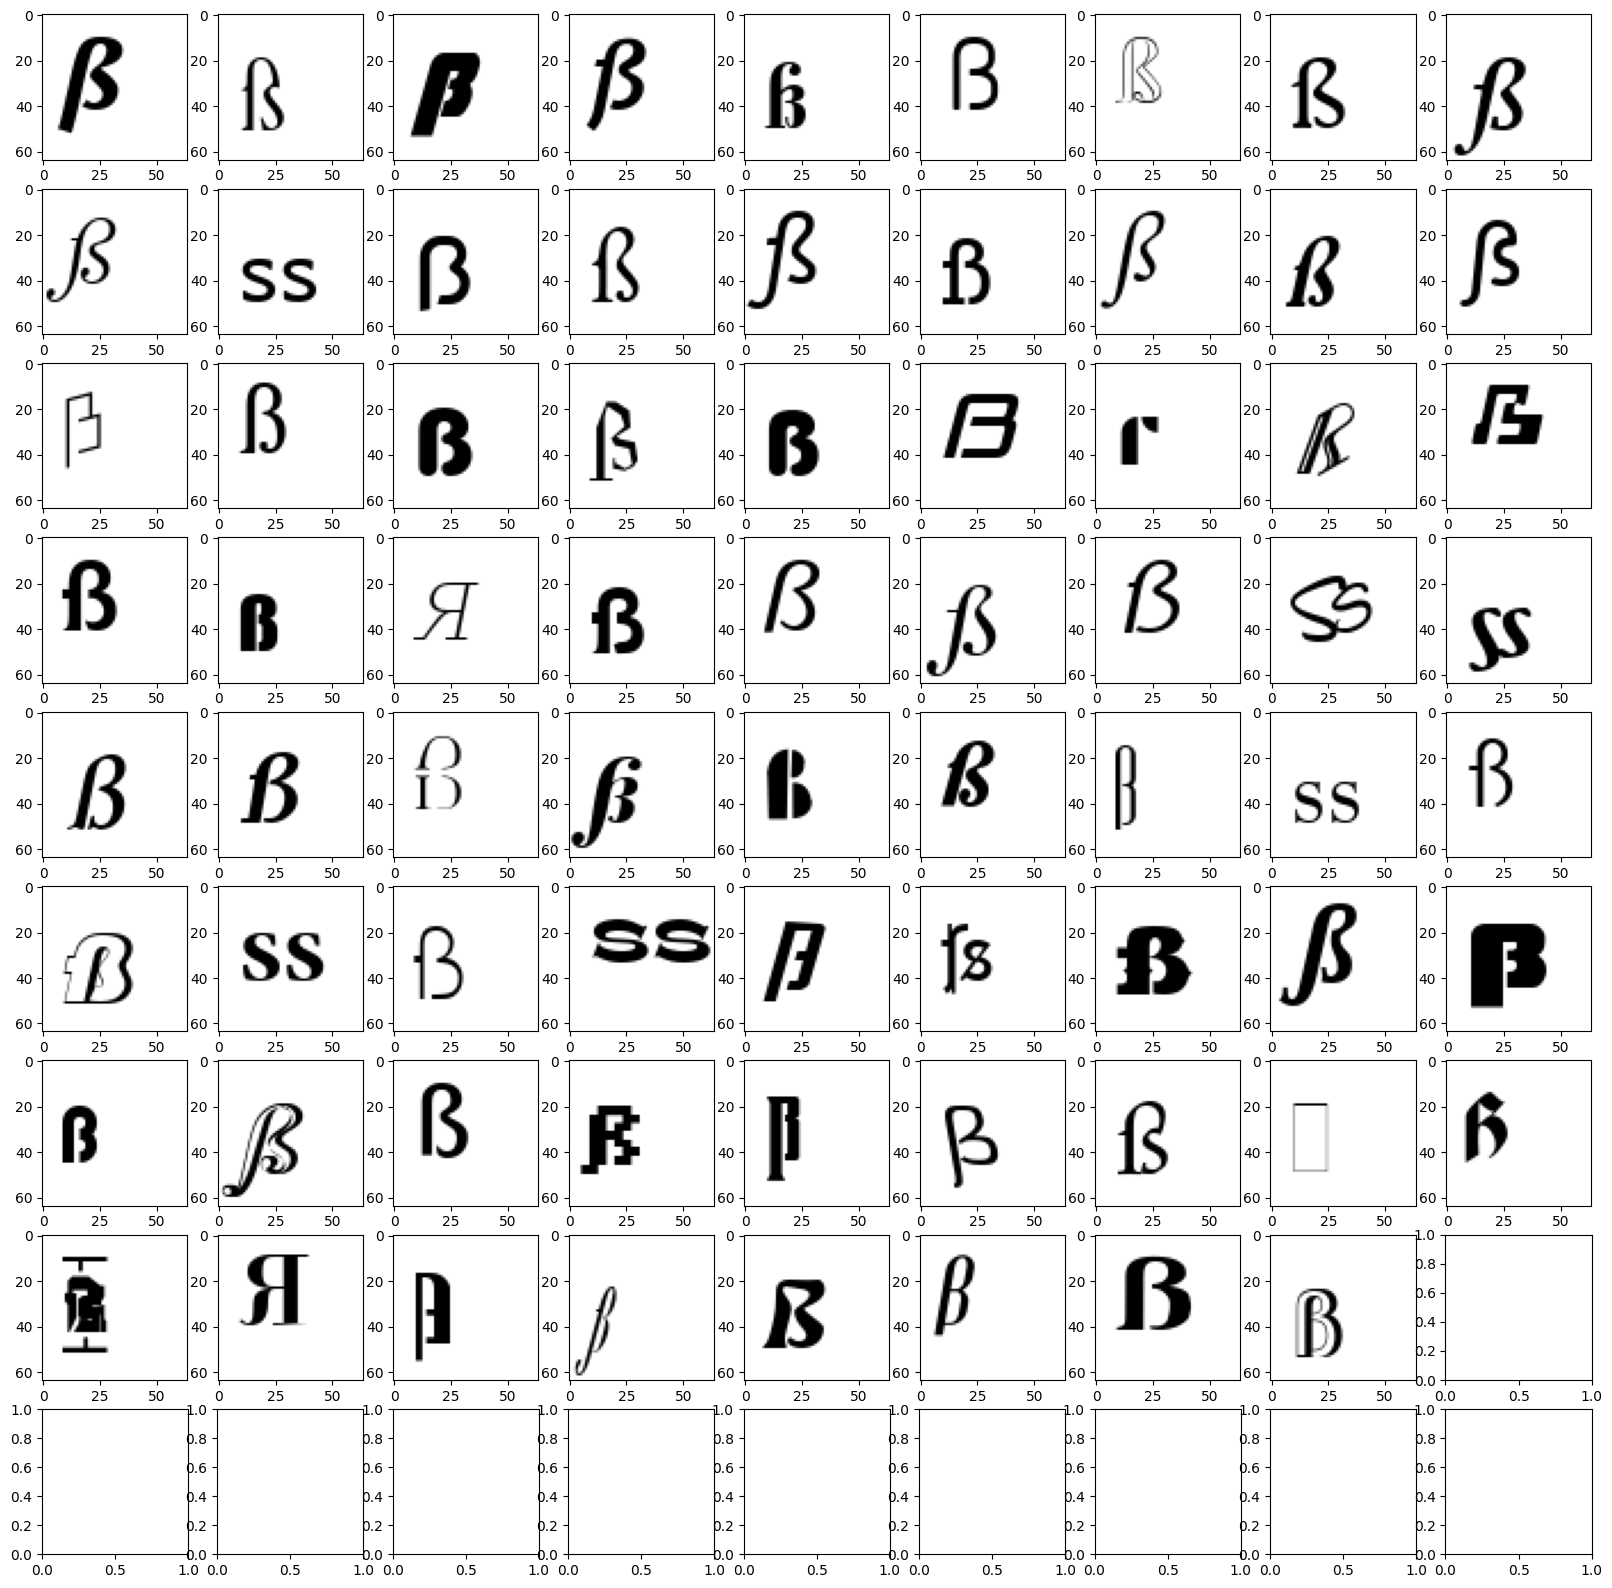

In [137]:
# Let's find the best boundaries for the accapted values for xMin_rel, yMin_rel, xMax_rel, yMax_rel
# New column in the dataframe "in_bounds" with True if all values are in bounds and False if not, default is True
font_data_df['in_bounds'] = True
# The boundaries for the relative values
xMin_rel_lower_bound = -0.2
xMax_rel_upper_bound = 1.5
yMin_rel_lower_bound = -0.3
yMax_rel_upper_bound = 0.95

font_data_df.loc[(font_data_df['xMin_rel'] < xMin_rel_lower_bound) | (font_data_df['xMax_rel'] > xMax_rel_upper_bound), 'in_bounds'] = False
font_data_df.loc[(font_data_df['yMin_rel'] < yMin_rel_lower_bound) | (font_data_df['yMax_rel'] > yMax_rel_upper_bound), 'in_bounds'] = False

# plotting the fonts within the bounds using the function plot_adieresis_and_sz
font_file_names_in_bounds = font_data_df[font_data_df['in_bounds']]['font_file_name'].tolist()
plot_adieresis_and_sz(path, font_file_names_in_bounds)

Overlay of glyphs to check if all fit in a pixel grid

71it [00:00, 126.37it/s]


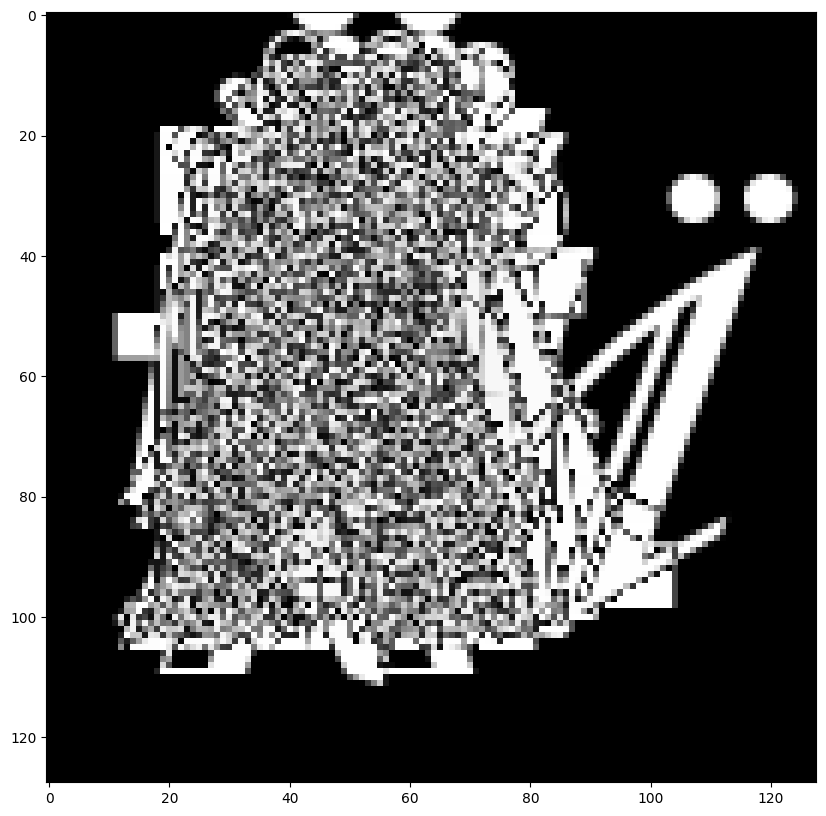

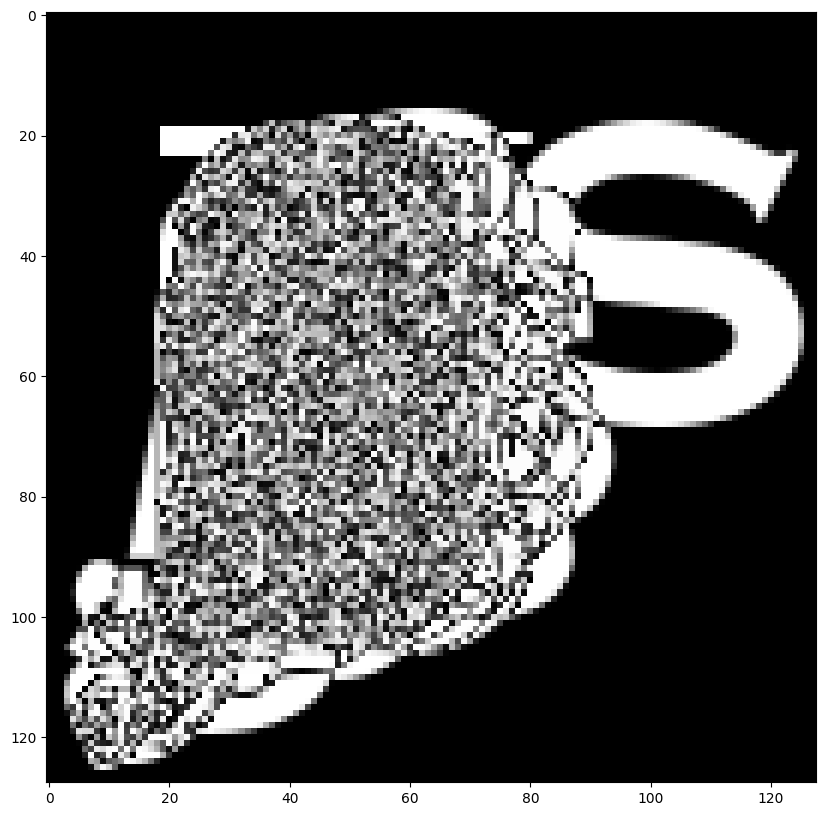

In [138]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
fig, ax2 = plt.subplots(1, 1, figsize=(10, 10))


for i, font_file_name in tqdm(enumerate(font_file_names_in_bounds)):
    font_file_name_path = os.path.join(path, font_file_name)
    font_array = render_font(font_file_name_path, 128)
    
    if i > 0:
        # sum of glyph_arrays for all iterations
        glyph_array = glyph_array + (255 - font_array[62])
        glyph_array_ = glyph_array_ + (255 - font_array[68])

    else:
        glyph_array = 255 - font_array[62]
        glyph_array_ = 255 - font_array[68]

glyph_array[glyph_array > 255] = 255
ax.imshow(glyph_array, cmap='gray')
ax2.imshow(glyph_array_, cmap='gray')


plt.show()